## Low-Rank Autoregressive Tensor Completion (LATC)

This notebook shows how to implement a LATC (with truncated nuclear norm) imputer on some real-world traffic data sets. To overcome the problem of missing values within multivariate time series data, this method takes into account both low-rank structure and time series regression. For an in-depth discussion of LATC, please see [1].

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> Xinyu Chen, Mengying Lei, Nicolas Saunier, Lijun Sun (2021). <b>Low-Rank Autorgressive Tensor Completion for Spatiotemporal Traffic Data Imputation</b>. arXiv:2104.14936. <a href="https://arxiv.org/abs/2104.14936" title="PDF"><b>[PDF]</b></a> 
</font>
</div>


### Define LATC-imputer kernel

We start by introducing some necessary functions that relies on `Numpy`.

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>ten2mat</code>:</b> <font color="black">Unfold tensor as matrix by specifying mode.</font></li>
<li><b><code>mat2ten</code>:</b> <font color="black">Fold matrix as tensor by specifying dimension (i.e, tensor size) and mode.</font></li>
<li><b><code>svt_tnn</code>:</b> <font color="black">Implement the process of Singular Value Thresholding (SVT).</font></li>
</ul>
</div>

In [ ]:
import numpy as np

def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, tensor_size[index].tolist(), order = 'F'), 0, mode)

In [ ]:
def svt_tnn(mat, tau, theta):
    [m, n] = mat.shape
    if 2 * m < n:
        u, s, v = np.linalg.svd(mat @ mat.T, full_matrices = 0)
        s = np.sqrt(s)
        idx = np.sum(s > tau)
        mid = np.zeros(idx)
        mid[: theta] = 1
        mid[theta : idx] = (s[theta : idx] - tau) / s[theta : idx]
        return (u[:, : idx] @ np.diag(mid)) @ (u[:, : idx].T @ mat)
    elif m > 2 * n:
        return svt_tnn(mat.T, tau, theta).T
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    idx = np.sum(s > tau)
    vec = s[: idx].copy()
    vec[theta : idx] = s[theta : idx] - tau
    return u[:, : idx] @ np.diag(vec) @ v[: idx, :]

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>compute_mape</code>:</b> <font color="black">Compute the value of Mean Absolute Percentage Error (MAPE).</font></li>
<li><b><code>compute_rmse</code>:</b> <font color="black">Compute the value of Root Mean Square Error (RMSE).</font></li>
</ul>
</div>

> Note that $$\mathrm{MAPE}=\frac{1}{n} \sum_{i=1}^{n} \frac{\left|y_{i}-\hat{y}_{i}\right|}{y_{i}} \times 100, \quad\mathrm{RMSE}=\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}},$$ where $n$ is the total number of estimated values, and $y_i$ and $\hat{y}_i$ are the actual value and its estimation, respectively.

In [ ]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

In [ ]:
def print_result(it, tol, var, var_hat):
    print('Iter: {}'.format(it))
    print('Tolerance: {:.6}'.format(tol))
    print('Imputation MAPE: {:.6}'.format(compute_mape(var, var_hat)))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(var, var_hat)))
    print()

How to create $\boldsymbol{\Psi}_{0},\boldsymbol{\Psi}_{1},\ldots,\boldsymbol{\Psi}_{d}$?

In [ ]:
from scipy import sparse
from scipy.sparse.linalg import spsolve as spsolve

def generate_Psi(dim_time, time_lags):
    Psis = []
    max_lag = np.max(time_lags)
    for i in range(len(time_lags) + 1):
        row = np.arange(0, dim_time - max_lag)
        if i == 0:
            col = np.arange(0, dim_time - max_lag) + max_lag
        else:
            col = np.arange(0, dim_time - max_lag) + max_lag - time_lags[i - 1]
        data = np.ones(dim_time - max_lag)
        Psi = sparse.coo_matrix((data, (row, col)), shape = (dim_time - max_lag, dim_time))
        Psis.append(Psi)
    return Psis

In [ ]:
import numpy as np

# Example
dim_time = 5
time_lags = np.array([1, 3])
Psis = generate_Psi(dim_time, time_lags)
print('Psi_0:')
print(Psis[0].toarray())
print()
print('Psi_1:')
print(Psis[1].toarray())
print()
print('Psi_2:')
print(Psis[2].toarray())
print()

Psi_0:
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]

Psi_1:
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]

Psi_2:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]



The main idea behind LATC-imputer is to approximate partially observed data with both low-rank structure and time series dynamics. The following `latc` kernel includes some necessary inputs:

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>dense_tensor</code>:</b> <font color="black">This is an input which has the ground truth for validation. If this input is not available, you could use <code>dense_tensor = sparse_tensor.copy()</code> instead.</font></li>
<li><b><code>sparse_tensor</code>:</b> <font color="black">This is a partially observed tensor which has many missing entries.</font></li>
<li><b><code>time_lags</code>:</b> <font color="black">Time lags, e.g., <code>time_lags = np.array([1, 2, 3])</code>. </font></li>
<li><b><code>alpha</code>:</b> <font color="black">Weights for tensors' nuclear norm, e.g., <code>alpha = np.ones(3) / 3</code>. </font></li>
<li><b><code>rho</code>:</b> <font color="black">Learning rate for ADMM, e.g., <code>rho = 0.0005</code>. </font></li>
<li><b><code>lambda0</code>:</b> <font color="black">Weight for time series regressor, e.g., <code>lambda0 = 5 * rho</code></font></li>
<li><b><code>theta</code>:</b> <font color="black">Integer-wise truncation for truncated nuclear norm, e.g., <code>theta = 5</code></font></li>
<li><b><code>epsilon</code>:</b> <font color="black">Stop criteria, e.g., <code>epsilon = 0.0001</code>. </font></li>
<li><b><code>maxiter</code>:</b> <font color="black">Maximum iteration to stop algorithm, e.g., <code>maxiter = 100</code>. </font></li>
</ul>
</div>

In [ ]:
from tqdm import tqdm

def latc(dense_tensor, sparse_tensor, time_lags, alpha, rho0, lambda0, theta, 
         epsilon = 1e-4, maxiter = 100, K = 3):
    """Low-Rank Autoregressive Tensor Completion (LATC)"""
    
    dim = np.array(sparse_tensor.shape)
    dim_time = int(np.prod(dim) / dim[0])
    d = len(time_lags)
    max_lag = np.max(time_lags)
    sparse_mat = ten2mat(sparse_tensor, 0)
    pos_missing = np.where(sparse_mat == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    dense_test = dense_tensor[pos_test]
    del dense_tensor
    
    T = np.zeros(dim)
    Z_tensor = sparse_tensor.copy()
    Z = sparse_mat.copy()
    A = 0.001 * np.random.rand(dim[0], d)
    Psis = generate_Psi(dim_time, time_lags)
    iden = sparse.coo_matrix((np.ones(dim_time), (np.arange(0, dim_time), np.arange(0, dim_time))), 
                             shape = (dim_time, dim_time))
    it = 0
    ind = np.zeros((d, dim_time - max_lag), dtype = np.int_)
    for i in range(d):
        ind[i, :] = np.arange(max_lag - time_lags[i], dim_time - time_lags[i])
    last_mat = sparse_mat.copy()
    snorm = np.linalg.norm(sparse_mat, 'fro')
    rho = rho0

    t = 0

    while True:
        temp = []
        t0 = time.time()
        for m in tqdm(range(dim[0]), total=dim[0]):
            Psis0 = Psis.copy()
            for i in range(d):
                Psis0[i + 1] = A[m, i] * Psis[i + 1]
            B = Psis0[0] - sum(Psis0[1 :])
            temp.append(B.T @ B)
        for k in tqdm(range(K), total=K):
            rho = min(rho * 1.05, 1e5)
            tensor_hat = np.zeros(dim)
            for p in range(len(dim)):
                tensor_hat += alpha[p] * mat2ten(svt_tnn(ten2mat(Z_tensor - T / rho, p), 
                                                         alpha[p] / rho, theta), dim, p)
            temp0 = rho / lambda0 * ten2mat(tensor_hat + T / rho, 0)
            mat = np.zeros((dim[0], dim_time))
            for m in range(dim[0]):
                mat[m, :] = spsolve(temp[m] + rho * iden / lambda0, temp0[m, :])
            Z[pos_missing] = mat[pos_missing]
            Z_tensor = mat2ten(Z, dim, 0)
            T = T + rho * (tensor_hat - Z_tensor)
        for m in tqdm(range(dim[0]), total=dim[0]):
            A[m, :] = np.linalg.lstsq(Z[m, ind].T, Z[m, max_lag :], rcond = None)[0]
        t1 = time.time()
        t += (t1 - t0)
        mat_hat = ten2mat(tensor_hat, 0)
        tol = np.linalg.norm((mat_hat - last_mat), 'fro') / snorm
        last_mat = mat_hat.copy()
        it += 1
        if it % 200 == 0:
            print_result(it, tol, dense_test, tensor_hat[pos_test])
        if (tol < epsilon) or (it >= maxiter):
            break
        else:
          print(f"tol = {tol} and epsilon = {epsilon}; it = {it} and maxiter = {maxiter}")
    print_result(it, tol, dense_test, tensor_hat[pos_test])
    
    return tensor_hat, t

> We use `spslove` of `scipy.sparse.linalg` for updating $\boldsymbol{Z}$ because computing the inverse of a large matrix directly is computationally expensive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/traffic_imputation/ ## change this

/content/drive/MyDrive/traffic_imputation/imputer


### Image data

In [ ]:
import numpy as np
import time

from PIL import Image

image_folder = "../datasets/image-data/"

im = Image.open(f'{image_folder}/mandril_color.tif')

imarray = np.array(im)

In [ ]:
import torch as T

def snr(tensor_ref, tensor_hat):
    return 20 * np.log10(T.norm(T.tensor(tensor_ref).float(), p='fro')/T.norm(T.tensor(tensor_ref-tensor_hat).float(), p='fro')).item()

In [ ]:
sparse_tensor_list = []
tensor_hat_list = []
time_list = []
snr_list = []

for r in [0.3, 0.5, 0.7]:
    print('Missing rate = {}'.format(r))
    missing_rate = r

    ## Matrix missing (RM)
    dense_tensor = imarray
    dim1, dim2, dim3 = dense_tensor.shape
    np.random.seed(1000)

    sparse_tensor = dense_tensor * np.repeat(np.round(np.random.rand(dim1, dim2) + 0.5 - missing_rate)[:, :, np.newaxis], 3, axis=2)
    
    start = time.time()
    time_lags = np.arange(1, 3)
    alpha = np.ones(3) / 3
    rho = 1e-5
    lambda0 = 10 * rho
    theta = 25
    tensor_hat, t = latc(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta)
    end = time.time()

    sparse_tensor_list.append(sparse_tensor)
    tensor_hat_list.append(tensor_hat)
    time_list.append(t)
    snr_list.append(snr(dense_tensor, tensor_hat))

    print(f"Runtime: {t}, snr metric: {snr}")
    print()

Missing rate = 0.3


100%|██████████| 512/512 [00:00<00:00, 12149.70it/s]


tol = 0.27113558648664426 and epsilon = 0.0001; it = 1 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10791.70it/s]


tol = 0.41411061766073193 and epsilon = 0.0001; it = 2 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11071.27it/s]


tol = 0.19089112035968764 and epsilon = 0.0001; it = 3 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10676.77it/s]


tol = 0.08105847254358438 and epsilon = 0.0001; it = 4 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10645.71it/s]


tol = 0.07059398451053712 and epsilon = 0.0001; it = 5 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9960.68it/s]


tol = 0.03676180947401069 and epsilon = 0.0001; it = 6 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 6310.49it/s]


tol = 0.09822046554663014 and epsilon = 0.0001; it = 7 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10507.77it/s]


tol = 0.07824754538891981 and epsilon = 0.0001; it = 8 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11384.09it/s]


tol = 0.08442872505066464 and epsilon = 0.0001; it = 9 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10203.37it/s]


tol = 0.0840264272066177 and epsilon = 0.0001; it = 10 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10729.64it/s]


tol = 0.08990807701436251 and epsilon = 0.0001; it = 11 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 12450.05it/s]


tol = 0.0955500965757362 and epsilon = 0.0001; it = 12 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10421.69it/s]


tol = 0.11143761620962107 and epsilon = 0.0001; it = 13 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 7288.52it/s]


tol = 0.12105163878536117 and epsilon = 0.0001; it = 14 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10795.55it/s]


tol = 0.12483889133339549 and epsilon = 0.0001; it = 15 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 12440.60it/s]


tol = 0.11942533098957545 and epsilon = 0.0001; it = 16 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11594.11it/s]


tol = 0.11316438832845949 and epsilon = 0.0001; it = 17 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11058.96it/s]


tol = 0.09840890778328266 and epsilon = 0.0001; it = 18 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11239.31it/s]


tol = 0.08221553242796477 and epsilon = 0.0001; it = 19 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10420.53it/s]


tol = 0.06821980843147536 and epsilon = 0.0001; it = 20 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11467.86it/s]


tol = 0.05526616618219445 and epsilon = 0.0001; it = 21 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11538.66it/s]


tol = 0.044410664805807416 and epsilon = 0.0001; it = 22 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11683.36it/s]


tol = 0.03559518851203519 and epsilon = 0.0001; it = 23 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10982.10it/s]


tol = 0.028314595749149532 and epsilon = 0.0001; it = 24 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11946.79it/s]


tol = 0.02261913082658596 and epsilon = 0.0001; it = 25 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10607.69it/s]


tol = 0.017958009325965904 and epsilon = 0.0001; it = 26 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11968.16it/s]


tol = 0.014225343755839632 and epsilon = 0.0001; it = 27 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 12259.78it/s]


tol = 0.011345575716244881 and epsilon = 0.0001; it = 28 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11524.92it/s]


tol = 0.00913507723478788 and epsilon = 0.0001; it = 29 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10605.54it/s]


tol = 0.007284801404993621 and epsilon = 0.0001; it = 30 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 12464.72it/s]


tol = 0.005684332632204492 and epsilon = 0.0001; it = 31 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11346.80it/s]


tol = 0.004566917169086043 and epsilon = 0.0001; it = 32 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10760.18it/s]


tol = 0.00385604428723152 and epsilon = 0.0001; it = 33 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10353.86it/s]


tol = 0.0031765423631899036 and epsilon = 0.0001; it = 34 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 6776.00it/s]


tol = 0.0026287926468418553 and epsilon = 0.0001; it = 35 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11962.63it/s]


tol = 0.0021122242131561223 and epsilon = 0.0001; it = 36 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10918.83it/s]


tol = 0.001610355636605645 and epsilon = 0.0001; it = 37 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 6201.96it/s]


tol = 0.0012655944830095266 and epsilon = 0.0001; it = 38 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 13559.14it/s]


tol = 0.0009056381145941897 and epsilon = 0.0001; it = 39 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11655.21it/s]


tol = 0.0006410331188339486 and epsilon = 0.0001; it = 40 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 7275.27it/s]


tol = 0.0005194316339000046 and epsilon = 0.0001; it = 41 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9702.41it/s]


tol = 0.00044841849089770607 and epsilon = 0.0001; it = 42 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11638.15it/s]


tol = 0.0003886063096892743 and epsilon = 0.0001; it = 43 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11104.88it/s]


tol = 0.000337078958210737 and epsilon = 0.0001; it = 44 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11851.06it/s]


tol = 0.0002924494952431486 and epsilon = 0.0001; it = 45 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11188.25it/s]


tol = 0.0002537026558289674 and epsilon = 0.0001; it = 46 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10678.37it/s]


tol = 0.00022003232312160382 and epsilon = 0.0001; it = 47 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 7941.29it/s]


tol = 0.00019076819190982133 and epsilon = 0.0001; it = 48 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11300.05it/s]


tol = 0.00016533861745781668 and epsilon = 0.0001; it = 49 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11174.22it/s]


tol = 0.00014324951499320284 and epsilon = 0.0001; it = 50 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11589.29it/s]


tol = 0.00012407090000592663 and epsilon = 0.0001; it = 51 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 12005.36it/s]


tol = 0.00010742735507963162 and epsilon = 0.0001; it = 52 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 12265.52it/s]


Iter: 53
Tolerance: 9.29907e-05
Imputation MAPE: 0.201242
Imputation RMSE: 21.8093

Runtime: 283.4599094390869, snr metric: <function snr at 0x7f9b22a38950>

Missing rate = 0.5


100%|██████████| 512/512 [00:00<00:00, 11265.96it/s]


tol = 0.27444451112637763 and epsilon = 0.0001; it = 1 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 6341.42it/s]


tol = 0.32507420693877165 and epsilon = 0.0001; it = 2 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9193.27it/s]


tol = 0.3424902872191264 and epsilon = 0.0001; it = 3 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11472.15it/s]


tol = 0.205891260141609 and epsilon = 0.0001; it = 4 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10665.64it/s]


tol = 0.05959874451045999 and epsilon = 0.0001; it = 5 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10556.79it/s]


tol = 0.06477161068851475 and epsilon = 0.0001; it = 6 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11551.08it/s]


tol = 0.02412713145601426 and epsilon = 0.0001; it = 7 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11538.11it/s]


tol = 0.04693007765440924 and epsilon = 0.0001; it = 8 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 8032.99it/s]


tol = 0.08273291568128188 and epsilon = 0.0001; it = 9 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 8086.84it/s]


tol = 0.056227722562929836 and epsilon = 0.0001; it = 10 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10303.73it/s]


tol = 0.06258182727414432 and epsilon = 0.0001; it = 11 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11049.00it/s]


tol = 0.06459461941594372 and epsilon = 0.0001; it = 12 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 7382.26it/s]


tol = 0.06321909149691739 and epsilon = 0.0001; it = 13 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9218.92it/s]


tol = 0.08487512045972555 and epsilon = 0.0001; it = 14 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10423.26it/s]


tol = 0.08639324283740209 and epsilon = 0.0001; it = 15 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 7949.49it/s]


tol = 0.09534070713134774 and epsilon = 0.0001; it = 16 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11028.23it/s]


tol = 0.08167077464979809 and epsilon = 0.0001; it = 17 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10777.19it/s]


tol = 0.06853806942248467 and epsilon = 0.0001; it = 18 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11276.37it/s]


tol = 0.053195315844452945 and epsilon = 0.0001; it = 19 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11283.36it/s]


tol = 0.03944426869454366 and epsilon = 0.0001; it = 20 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11861.93it/s]


tol = 0.02785488291756362 and epsilon = 0.0001; it = 21 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10757.37it/s]


tol = 0.01867074381703906 and epsilon = 0.0001; it = 22 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10331.54it/s]


tol = 0.01159323021498693 and epsilon = 0.0001; it = 23 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9896.79it/s]


tol = 0.007592994656246358 and epsilon = 0.0001; it = 24 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11497.70it/s]


tol = 0.0062567718691759035 and epsilon = 0.0001; it = 25 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11238.54it/s]


tol = 0.005588317068266952 and epsilon = 0.0001; it = 26 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 12029.98it/s]


tol = 0.004997231041579958 and epsilon = 0.0001; it = 27 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10845.49it/s]


tol = 0.004469102975303718 and epsilon = 0.0001; it = 28 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9776.98it/s]


tol = 0.003995525483833806 and epsilon = 0.0001; it = 29 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9536.74it/s]


tol = 0.003564933125266461 and epsilon = 0.0001; it = 30 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11076.47it/s]


tol = 0.0031765895080785155 and epsilon = 0.0001; it = 31 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10394.30it/s]


tol = 0.0028225311140516783 and epsilon = 0.0001; it = 32 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11408.52it/s]


tol = 0.002497840124715083 and epsilon = 0.0001; it = 33 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10024.10it/s]


tol = 0.002203975052130886 and epsilon = 0.0001; it = 34 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10866.95it/s]


tol = 0.0019311288946300602 and epsilon = 0.0001; it = 35 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11484.67it/s]


tol = 0.0016824431919295383 and epsilon = 0.0001; it = 36 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 8391.26it/s]


tol = 0.001462123383879768 and epsilon = 0.0001; it = 37 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10110.75it/s]


tol = 0.0012689015442274706 and epsilon = 0.0001; it = 38 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10508.13it/s]


tol = 0.0011091439262129704 and epsilon = 0.0001; it = 39 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10337.11it/s]


tol = 0.0009751278672303004 and epsilon = 0.0001; it = 40 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11450.13it/s]


tol = 0.0008576275423640046 and epsilon = 0.0001; it = 41 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11347.88it/s]


tol = 0.0007533970656013729 and epsilon = 0.0001; it = 42 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10057.15it/s]


tol = 0.0006607781665252225 and epsilon = 0.0001; it = 43 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 6286.05it/s]


tol = 0.0005785936726283447 and epsilon = 0.0001; it = 44 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11463.09it/s]


tol = 0.0005058411023219496 and epsilon = 0.0001; it = 45 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11950.58it/s]


tol = 0.0004416036128632492 and epsilon = 0.0001; it = 46 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10462.77it/s]


tol = 0.0003850258269931602 and epsilon = 0.0001; it = 47 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9949.47it/s]


tol = 0.00033530931481650923 and epsilon = 0.0001; it = 48 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 8189.06it/s]


tol = 0.0002917132883005007 and epsilon = 0.0001; it = 49 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10613.09it/s]


tol = 0.00025355577099061785 and epsilon = 0.0001; it = 50 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11230.49it/s]


tol = 0.00022021380333418466 and epsilon = 0.0001; it = 51 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 7238.73it/s]


tol = 0.00019112241600502638 and epsilon = 0.0001; it = 52 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10836.74it/s]


tol = 0.00016577251409808941 and epsilon = 0.0001; it = 53 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11679.80it/s]


tol = 0.00014370793616204754 and epsilon = 0.0001; it = 54 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10743.76it/s]


tol = 0.0001245219602703061 and epsilon = 0.0001; it = 55 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11308.62it/s]


tol = 0.0001078534953493107 and epsilon = 0.0001; it = 56 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11808.77it/s]


Iter: 57
Tolerance: 9.33831e-05
Imputation MAPE: 0.222544
Imputation RMSE: 24.1542

Runtime: 304.03373861312866, snr metric: <function snr at 0x7f9b22a38950>

Missing rate = 0.7


100%|██████████| 512/512 [00:00<00:00, 11374.93it/s]


tol = 0.30463930553222274 and epsilon = 0.0001; it = 1 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11329.14it/s]


tol = 0.24310126072175245 and epsilon = 0.0001; it = 2 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 12168.08it/s]


tol = 0.20173673452583146 and epsilon = 0.0001; it = 3 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11677.01it/s]


tol = 0.31880033246911954 and epsilon = 0.0001; it = 4 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9318.17it/s]


tol = 0.3418703868176845 and epsilon = 0.0001; it = 5 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10900.10it/s]


tol = 0.2261459356714485 and epsilon = 0.0001; it = 6 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11369.93it/s]


tol = 0.20545133886743897 and epsilon = 0.0001; it = 7 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 8193.84it/s]


tol = 0.08647640010571465 and epsilon = 0.0001; it = 8 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10844.51it/s]


tol = 0.09424967681603082 and epsilon = 0.0001; it = 9 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11238.66it/s]


tol = 0.0503021112497289 and epsilon = 0.0001; it = 10 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9255.96it/s]


tol = 0.06745545647926614 and epsilon = 0.0001; it = 11 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10155.32it/s]


tol = 0.07958363123530902 and epsilon = 0.0001; it = 12 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11070.36it/s]


tol = 0.050826294047027654 and epsilon = 0.0001; it = 13 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11764.00it/s]


tol = 0.08654572226506664 and epsilon = 0.0001; it = 14 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 8523.01it/s]


tol = 0.07353466147474268 and epsilon = 0.0001; it = 15 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10234.35it/s]


tol = 0.09006634001099849 and epsilon = 0.0001; it = 16 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10029.77it/s]


tol = 0.09165708688036604 and epsilon = 0.0001; it = 17 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9282.56it/s]


tol = 0.0725900943840346 and epsilon = 0.0001; it = 18 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11366.62it/s]


tol = 0.044181184044081286 and epsilon = 0.0001; it = 19 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10464.61it/s]


tol = 0.02262242036199827 and epsilon = 0.0001; it = 20 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10249.64it/s]


tol = 0.016446814035622172 and epsilon = 0.0001; it = 21 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10700.23it/s]


tol = 0.013915435988401375 and epsilon = 0.0001; it = 22 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10058.85it/s]


tol = 0.012349640165042112 and epsilon = 0.0001; it = 23 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9747.60it/s]


tol = 0.011085463287375048 and epsilon = 0.0001; it = 24 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9703.99it/s]


tol = 0.009979253282257225 and epsilon = 0.0001; it = 25 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11774.78it/s]


tol = 0.008971101376327765 and epsilon = 0.0001; it = 26 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11060.04it/s]


tol = 0.008062825363244947 and epsilon = 0.0001; it = 27 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10916.67it/s]


tol = 0.007236463635301856 and epsilon = 0.0001; it = 28 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9203.99it/s]


tol = 0.0064908752580182145 and epsilon = 0.0001; it = 29 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10468.79it/s]


tol = 0.005821701905017852 and epsilon = 0.0001; it = 30 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10932.84it/s]


tol = 0.005219570283286411 and epsilon = 0.0001; it = 31 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9081.57it/s]


tol = 0.004679710686158675 and epsilon = 0.0001; it = 32 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9767.82it/s]


tol = 0.004192861932735444 and epsilon = 0.0001; it = 33 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11070.07it/s]


tol = 0.0037464651133379662 and epsilon = 0.0001; it = 34 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10621.48it/s]


tol = 0.003340944722676329 and epsilon = 0.0001; it = 35 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10015.83it/s]


tol = 0.0029702947667188243 and epsilon = 0.0001; it = 36 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9668.43it/s]


tol = 0.0026329664313572056 and epsilon = 0.0001; it = 37 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10240.35it/s]


tol = 0.0023283377113539616 and epsilon = 0.0001; it = 38 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10438.11it/s]


tol = 0.0020502546221483698 and epsilon = 0.0001; it = 39 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10714.92it/s]


tol = 0.0017991503037278443 and epsilon = 0.0001; it = 40 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9724.03it/s]


tol = 0.0015738719886553257 and epsilon = 0.0001; it = 41 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9453.28it/s]


tol = 0.0013725665165074813 and epsilon = 0.0001; it = 42 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11107.18it/s]


tol = 0.0011920898734396135 and epsilon = 0.0001; it = 43 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11433.61it/s]


tol = 0.0010339000636328094 and epsilon = 0.0001; it = 44 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9864.19it/s]


tol = 0.0008965431587043705 and epsilon = 0.0001; it = 45 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11458.69it/s]


tol = 0.0007783085258446807 and epsilon = 0.0001; it = 46 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 8593.72it/s]


tol = 0.0006773174362199053 and epsilon = 0.0001; it = 47 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 7607.53it/s]


tol = 0.0005898348887120462 and epsilon = 0.0001; it = 48 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10329.61it/s]


tol = 0.0005135676872054546 and epsilon = 0.0001; it = 49 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 8676.35it/s]


tol = 0.0004469238127950816 and epsilon = 0.0001; it = 50 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11896.95it/s]


tol = 0.00038866606124773797 and epsilon = 0.0001; it = 51 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10429.39it/s]


tol = 0.00033776439307598956 and epsilon = 0.0001; it = 52 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9610.23it/s]


tol = 0.00029332914815755507 and epsilon = 0.0001; it = 53 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 8979.99it/s]


tol = 0.0002545782940137167 and epsilon = 0.0001; it = 54 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 11479.39it/s]


tol = 0.00022081941725756856 and epsilon = 0.0001; it = 55 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10488.47it/s]


tol = 0.00019143825921675098 and epsilon = 0.0001; it = 56 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9821.92it/s]


tol = 0.00016589024225385196 and epsilon = 0.0001; it = 57 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9955.05it/s]


tol = 0.00014369344278465122 and epsilon = 0.0001; it = 58 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10372.51it/s]


tol = 0.00012442235335453268 and epsilon = 0.0001; it = 59 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 9409.83it/s]


tol = 0.00010770216783149017 and epsilon = 0.0001; it = 60 and maxiter = 100


100%|██████████| 512/512 [00:00<00:00, 10425.03it/s]

Iter: 61
Tolerance: 9.32035e-05
Imputation MAPE: 0.254425
Imputation RMSE: 27.4573

Runtime: 326.6286690235138, snr metric: <function snr at 0x7f9b22a38950>



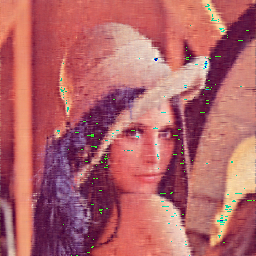

In [ ]:
Image.fromarray(np.array(tensor_hat, dtype=np.uint8))

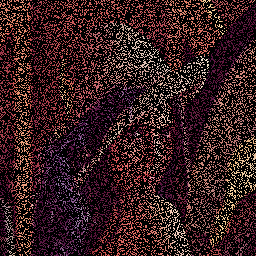

In [ ]:
Image.fromarray(np.array(sparse_tensor, dtype=np.uint8))

In [ ]:
snr_list

[20.855436325073242, 17.732579708099365, 15.17077088356018]

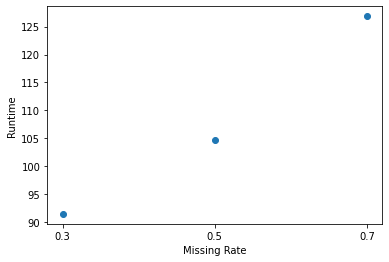

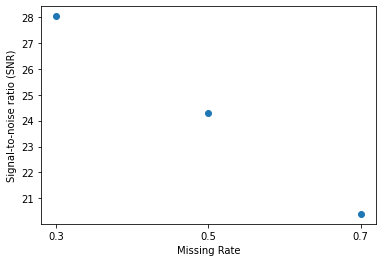

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter([0.3, 0.5, 0.7], time_list)
plt.xlabel("Missing Rate")
plt.xticks([0.3, 0.5, 0.7], [0.3, 0.5, 0.7])
plt.ylabel("Runtime")
plt.savefig(f"{image_folder}/lena_color_runtime.eps", format='eps', dpi=300, bbox_inches='tight')

plt.figure(figsize=(6, 4))
plt.scatter([0.3, 0.5, 0.7], snr_list)
plt.xlabel("Missing Rate")
plt.xticks([0.3, 0.5, 0.7], [0.3, 0.5, 0.7])
plt.ylabel("Signal-to-noise ratio (SNR)")
plt.savefig(f"{image_folder}/lena_color_snr.eps", format='eps', dpi=300, bbox_inches='tight')

In [ ]:
for i, r in enumerate([0.3, 0.5, 0.7]):
    im_1 = Image.fromarray(np.array(sparse_tensor_list[i], dtype=np.uint8))
    im_1.save(f"{image_folder}/lena_color_observed_missing={r}.eps", format='eps')

    im_2 = Image.fromarray(np.array(tensor_hat_list[i], dtype=np.uint8))
    im_2.save(f"{image_folder}/lena_color_impainted_missing={r}.eps", format='eps')

### Seattle freeway traffic speed data set

In [ ]:
import numpy as np
import time

for r in [0.3]:
    print('Missing rate = {}'.format(r))
    missing_rate = r

    ## Random missing (RM)
    dense_tensor = np.load('../datasets/Seattle-data-set/tensor.npz')['arr_0'].transpose(0, 2, 1)
    dim1, dim2, dim3 = dense_tensor.shape
    np.random.seed(1000)
    sparse_tensor = dense_tensor * np.round(np.random.rand(dim1, dim2, dim3) + 0.5 - missing_rate)

    start = time.time()
    time_lags = np.arange(1, 7)
    alpha = np.ones(3) / 3
    rho = 1e-5
    lambda0 = 10 * rho
    theta = 25
    tensor_hat = latc(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()

Missing rate = 0.3


100%|██████████| 323/323 [00:00<00:00, 982.21it/s] 


tol = 0.5504424362676488 and epsilon = 0.0001; it = 1 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1110.60it/s]


tol = 0.4051457497146526 and epsilon = 0.0001; it = 2 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 970.00it/s] 


tol = 0.0677320203363396 and epsilon = 0.0001; it = 3 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1092.20it/s]


tol = 0.1618823426874572 and epsilon = 0.0001; it = 4 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1074.56it/s]


tol = 0.19742109876390007 and epsilon = 0.0001; it = 5 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 857.40it/s]


tol = 0.1322015743197238 and epsilon = 0.0001; it = 6 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1001.00it/s]


tol = 0.1325259132645055 and epsilon = 0.0001; it = 7 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1106.11it/s]


tol = 0.14250950088181988 and epsilon = 0.0001; it = 8 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1030.30it/s]


tol = 0.16395917277107253 and epsilon = 0.0001; it = 9 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1101.61it/s]


tol = 0.15487788597147137 and epsilon = 0.0001; it = 10 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1023.97it/s]


tol = 0.13352625861349252 and epsilon = 0.0001; it = 11 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1108.47it/s]


tol = 0.11542392661276142 and epsilon = 0.0001; it = 12 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 984.92it/s] 


tol = 0.09442530020018203 and epsilon = 0.0001; it = 13 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1012.13it/s]


tol = 0.08005958967214077 and epsilon = 0.0001; it = 14 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1166.96it/s]


tol = 0.059611531612615384 and epsilon = 0.0001; it = 15 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1064.53it/s]


tol = 0.05607052305958404 and epsilon = 0.0001; it = 16 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 427.63it/s]


tol = 0.04306100235218838 and epsilon = 0.0001; it = 17 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1126.91it/s]


tol = 0.04054775632190562 and epsilon = 0.0001; it = 18 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1006.30it/s]


tol = 0.0355780181862386 and epsilon = 0.0001; it = 19 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1009.79it/s]


tol = 0.03258277778375277 and epsilon = 0.0001; it = 20 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1054.84it/s]


tol = 0.03464102208352794 and epsilon = 0.0001; it = 21 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1068.45it/s]


tol = 0.03239242020319497 and epsilon = 0.0001; it = 22 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1084.34it/s]


tol = 0.029940331787630066 and epsilon = 0.0001; it = 23 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1035.79it/s]


tol = 0.026006389334538457 and epsilon = 0.0001; it = 24 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1126.00it/s]


tol = 0.022587093442157386 and epsilon = 0.0001; it = 25 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1055.49it/s]


tol = 0.01977632234310364 and epsilon = 0.0001; it = 26 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1060.40it/s]


tol = 0.016541702397256185 and epsilon = 0.0001; it = 27 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1020.83it/s]


tol = 0.01355032317147838 and epsilon = 0.0001; it = 28 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 970.53it/s]


tol = 0.011059804628327905 and epsilon = 0.0001; it = 29 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1023.74it/s]


tol = 0.008658625918975522 and epsilon = 0.0001; it = 30 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 977.50it/s] 


tol = 0.006849198252404225 and epsilon = 0.0001; it = 31 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1072.22it/s]


tol = 0.005273904779053974 and epsilon = 0.0001; it = 32 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1035.54it/s]


tol = 0.00401919425603149 and epsilon = 0.0001; it = 33 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1092.37it/s]


tol = 0.002967414293104913 and epsilon = 0.0001; it = 34 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 441.25it/s]


tol = 0.00211582272621899 and epsilon = 0.0001; it = 35 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1098.74it/s]


tol = 0.0014893527512592787 and epsilon = 0.0001; it = 36 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1015.72it/s]


tol = 0.0010249962423335814 and epsilon = 0.0001; it = 37 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1001.80it/s]


tol = 0.0006528139786801062 and epsilon = 0.0001; it = 38 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1026.10it/s]


tol = 0.00032260299800950605 and epsilon = 0.0001; it = 39 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1078.24it/s]


tol = 0.00018230420233906482 and epsilon = 0.0001; it = 40 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1025.22it/s]


tol = 0.00015208577177883148 and epsilon = 0.0001; it = 41 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1084.08it/s]


tol = 0.00013270077316993818 and epsilon = 0.0001; it = 42 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1052.67it/s]


tol = 0.00011575048834641864 and epsilon = 0.0001; it = 43 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1048.54it/s]


tol = 0.00010084397564492426 and epsilon = 0.0001; it = 44 and maxiter = 100


100%|██████████| 323/323 [00:00<00:00, 1085.04it/s]


Iter: 45
Tolerance: 8.77537e-05
Imputation MAPE: 0.0489625
Imputation RMSE: 3.15583

Running time: 648 seconds



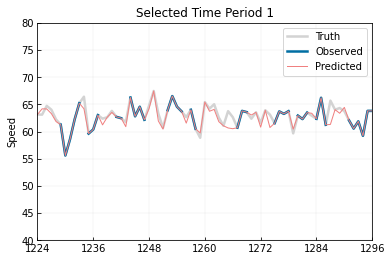

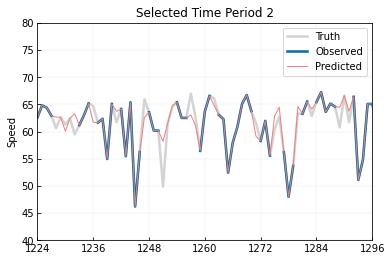

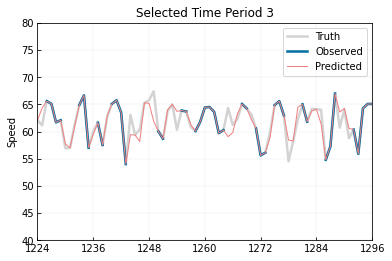

In [ ]:
import matplotlib.pyplot as plt

dense_mat = dense_tensor.reshape([dense_tensor.shape[0], dense_tensor.shape[1] * dense_tensor.shape[2]])
sparse_mat = sparse_tensor.reshape([sparse_tensor.shape[0], sparse_tensor.shape[1] * sparse_tensor.shape[2]])
sparse_mat[ sparse_mat==0 ] = np.nan

dense_mat_hat = tensor_hat.reshape([tensor_hat.shape[0], tensor_hat.shape[1] * tensor_hat.shape[2]])

N = 3
i = 1
for loc in np.arange(N):
    fig = plt.figure(figsize = (6, 4))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(dense_mat[loc - 166, :], color = "lightgray", linewidth = 2.5, label='Truth')
    plt.plot(sparse_mat[loc - 166, :], color = "#006ea3", linewidth = 2.5, label='Observed')
    plt.plot(dense_mat_hat[loc - 166, :], color="lightcoral", linewidth=1, label='Predicted')
    plt.xticks(np.arange(0, 72 + 1, 12), 
               np.arange(4 * 288 + 72, 4 * 288 + 144 + 1, 12))
    # if i != N:
    #     plt.setp(ax.get_xticklabels(), visible = False)
    plt.grid(axis = 'both', linestyle = "--", linewidth = 0.1, color = 'gray')
    plt.ylabel('Speed')
    plt.title('Selected Time Period {}'.format(loc + 1))
    ax.tick_params(direction = "in")
    ax.set_xlim([0, 72])
    ax.set_ylim([40, 80])
    i += 1
    plt.legend()
    plt.show()

In [ ]:
import numpy as np
import time

for r in [0.3, 0.7]:
    print('Missing rate = {}'.format(r))
    missing_rate = r

    ## Non-random Missing (NM)
    dense_tensor = np.load('../datasets/Seattle-data-set/tensor.npz')['arr_0'].transpose(0, 2, 1)
    dim1, dim2, dim3 = dense_tensor.shape
    np.random.seed(1000)
    sparse_tensor = dense_tensor * np.round(np.random.rand(dim1, dim3) + 0.5 - missing_rate)[:, None, :]

    start = time.time()
    time_lags = np.arange(1, 7)
    alpha = np.ones(3) / 3
    rho = 1e-5
    lambda0 = 10 * rho
    if r == 0.3:
        theta = 25
    elif r == 0.7:
        theta = 10
    tensor_hat = latc(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()

Missing rate = 0.3
Total iteration: 46
Tolerance: 9.90209e-05
Imputation MAPE: 0.0710509
Imputation RMSE: 4.32765

Running time: 718 seconds

Missing rate = 0.7
Total iteration: 54
Tolerance: 9.08842e-05
Imputation MAPE: 0.0946159
Imputation RMSE: 5.42155

Running time: 796 seconds



In [ ]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.3

## Block-out Missing (BM)
dense_tensor = np.load('../datasets/Seattle-data-set/tensor.npz')['arr_0'].transpose(0, 2, 1)
dim1, dim2, dim3 = dense_tensor.shape
block_window = 12
vec = np.random.rand(int(dim2 * dim3 / block_window))
temp = np.array([vec] * block_window)
vec = temp.reshape([dim2 * dim3], order = 'F')
sparse_tensor = dense_tensor * mat2ten(np.ones((dim1, dim2 * dim3)) * np.round(vec + 0.5 - missing_rate)[None, :], np.array([dim1, dim2, dim3]), 0)

start = time.time()
time_lags = np.arange(1, 7)
alpha = np.ones(3) / 3
rho = 1e-5
lambda0 = 10 * rho
theta = 10
tensor_hat = latc(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta)
end = time.time()
print('Running time: %d seconds'%(end - start))
print()

Total iteration: 48
Tolerance: 8.98277e-05
Imputation MAPE: 0.094364
Imputation RMSE: 5.35739

Running time: 704 seconds

